In [1]:
import json
import time
from functools import reduce

import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tqdm.autonotebook import tqdm

from py2neo import Graph, Node, Relationship

In [2]:
graph = Graph("bolt://dev_neo4j:7687", auth=('neo4j','myneo'))

n_nodes = graph.database.primitive_counts['NumberOfNodeIdsInUse']
n_relationships = graph.database.primitive_counts['NumberOfRelationshipIdsInUse']
print("Connected to graph database with {:,} nodes and {:,} relationships!".format
     (n_nodes, n_relationships))

def run_query(query, graph, print_query=False, run_query=True, 
              print_only=False, to_df=False, verbose=True):
    df = 1
    if print_only: 
        print_query = True
        run_query = False
    start_time = time.time()
    if print_query:
        print(query)
    if run_query:
        if to_df:
            df = graph.run(query).to_data_frame()
        else:
            graph.run(query)
    end_time = time.time()
    minutes_elapsed = (end_time-start_time)/60
    if verbose:
        print("Query completed in {:.2f} minutes.".format(minutes_elapsed))
    return df

Connected to graph database with 370,269,897 nodes and 220,155,390 relationships!


In [41]:
# Collect data
min_year, max_year = 1990, 2015

# Collect positive class data
query = """
MATCH (q:Quanta)-[:PUBLISHED_IN]->(y:Year)
WHERE y.value>{miny} AND y.value < {maxy}-10
MATCH (q)-[m0:METRICS_IN]->(:Year {{value:y.value}})
MATCH (q)-[m1:METRICS_IN]->(:Year {{value:y.value+1}})
MATCH (q)-[m10:METRICS_IN]->(:Year {{value:y.value+10}})
WITH q, y, m0, m1, m10
WHERE m10.timeScaledPageRank > .7
RETURN 
    id(q) AS id, 
    y.value AS year, 
    coalesce(m0.earlyAdopters,0) AS earlyAdopters_0,
    coalesce(m0.timeScaledPageRank, 0) AS timeScaledPageRank_0,
    coalesce(m0.cites, 0) as cites_0,
    coalesce(m0.node2vec, 0) AS node2vec_0,
    coalesce(m1.earlyAdopters,0) AS earlyAdopters_1,
    coalesce(m1.timeScaledPageRank, 0) AS timeScaledPageRank_1,
    coalesce(m1.cites, 0) as cites_1,
    coalesce(m1.node2vec, 0) AS node2vec_1,
    1 AS is_high_impact
LIMIT 100000
""".format(miny=min_year, maxy=max_year)
df_pos = run_query(query, graph, to_df=True, print_only=False)

# Collect negative class data
query = """
MATCH (q:Quanta)-[:PUBLISHED_IN]->(y:Year)
WHERE y.value>{miny} AND y.value < {maxy}-10
MATCH (q)-[m0:METRICS_IN]->(:Year {{value:y.value}})
MATCH (q)-[m1:METRICS_IN]->(:Year {{value:y.value+1}})
MATCH (q)-[m10:METRICS_IN]->(:Year {{value:y.value+10}})
WITH q, y, m0, m1, m10
WHERE m10.timeScaledPageRank < .7
RETURN 
    id(q) AS id, 
    y.value AS year, 
    coalesce(m0.earlyAdopters,0) AS earlyAdopters_0,
    coalesce(m0.timeScaledPageRank, 0) AS timeScaledPageRank_0,
    coalesce(m0.cites, 0) as cites_0,
    coalesce(m0.node2vec, 0) AS node2vec_0,
    coalesce(m1.earlyAdopters,0) AS earlyAdopters_1,
    coalesce(m1.timeScaledPageRank,0) AS timeScaledPageRank_1,
    coalesce(m1.cites, 0) as cites_1,
    coalesce(m1.node2vec, 0) AS node2vec_1,
    0 AS is_high_impact
LIMIT 100000
""".format(miny=min_year, maxy=max_year)
df_neg = run_query(query, graph, to_df=True, print_only=False)

Query completed in 1.39 minutes.
Query completed in 0.41 minutes.


In [42]:
df = pd.concat([df_pos, df_neg])

df = pd.concat([df, df.loc[:,'node2vec_0'].apply(pd.Series)], axis=1) \
        .rename(columns=dict(zip(range(10), ["node2vec_0_{}".format(i) for i in range(10)])))

df = pd.concat([df, df.loc[:,'node2vec_1'].apply(pd.Series)], axis=1) \
        .rename(columns=dict(zip(range(10), ["node2vec_1_{}".format(i) for i in range(10)])))

df = df.drop(['node2vec_0', 'node2vec_1', 'year'], axis=1)
# df = df.dropna()

df.describe()

,cites_0,cites_1,earlyAdopters_0,earlyAdopters_1,id,is_high_impact,timeScaledPageRank_0,timeScaledPageRank_1,node2vec_0_0,node2vec_0_1,...,node2vec_1_0,node2vec_1_1,node2vec_1_2,node2vec_1_3,node2vec_1_4,node2vec_1_5,node2vec_1_6,node2vec_1_7,node2vec_1_8,node2vec_1_9
count,148340.000000,148340.000000,148340.000000,148340.000000,1.483400e+05,148340.000000,148340.000000,148340.000000,148340.000000,65031.000000,...,148340.000000,76569.000000,76569.000000,76569.000000,76569.000000,76569.000000,76569.000000,76569.000000,76569.000000,76569.000000
mean,0.519981,1.472860,3.058177,10.169799,3.523017e+07,0.325873,0.454398,0.738310,-0.023572,0.006617,...,-6.234488,2.908465,97.923556,95.476976,770.610286,416.571134,85.569884,91.304835,-63.375442,-334.785885
std,1.491240,3.375249,14.929380,30.794997,8.705288e+07,0.468702,1.239909,1.619709,0.112766,0.152005,...,329.757345,562.019356,1109.340299,984.675686,5385.489269,2923.477401,2178.417131,2591.871688,828.992895,3791.291361
min,0.000000,0.000000,0.000000,0.000000,3.320000e+02,0.000000,0.000220,0.000010,-4.575590,-4.668820,...,-49636.400000,-10607.200000,-24637.400000,-49752.400000,-32855.500000,-26336.800000,-116402.000000,-139298.000000,-50807.300000,-104961.000000
25%,0.000000,0.000000,0.000000,0.000000,4.938725e+05,0.000000,0.190337,0.230315,-0.018031,-0.074200,...,-0.054562,-0.076775,-0.095397,-0.068477,-0.065232,-0.097281,-0.096958,-0.109114,-0.241753,-0.161109
50%,0.000000,0.000000,0.000000,0.000000,1.084722e+06,0.000000,0.208094,0.236632,0.000000,-0.004018,...,0.000000,-0.001138,0.067863,0.020423,0.024656,0.038391,0.008141,0.024034,-0.028223,-0.010694
75%,0.000000,2.000000,0.000000,8.000000,1.628483e+06,1.000000,0.211260,0.441323,0.000000,0.076227,...,0.000000,0.086030,0.204560,0.108628,0.152002,0.154515,0.107757,0.157968,0.168145,0.189590
max,99.000000,127.000000,1289.000000,2186.000000,2.571403e+08,1.000000,63.953645,81.699064,5.533990,5.537820,...,19957.100000,57221.400000,96161.000000,34779.100000,190779.000000,101944.000000,66388.300000,80334.000000,29596.100000,80980.300000


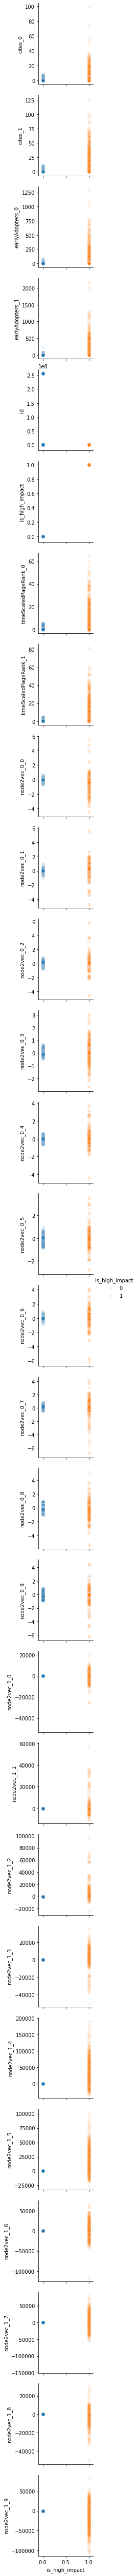

In [43]:
import seaborn as sns
g = sns.pairplot(df, 
                 y_vars=df.columns, 
                 x_vars=['is_high_impact'],
                 hue='is_high_impact', plot_kws=dict(s=50, alpha=0.1))

In [33]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [58]:
df['is_high_impact'].value_counts()

1    42186
0    10952
Name: is_high_impact, dtype: int64

In [57]:
count_class_0, count_class_1 = df['is_high_impact'].value_counts()
df_class_0 = df[df['is_high_impact'] == 0]
df_class_1 = df[df['is_high_impact'] == 1]

# df_class_0_under = df_class_0.sample(count_class_1)
df_class_1_under = df_class_1.sample(count_class_0)

df = pd.concat([df_class_1_under, df_class_0], axis=0)

df['is_high_impact'].value_counts()

1    42186
0    10952
Name: is_high_impact, dtype: int64

In [49]:
columns_to_keep = df.columns[df.columns!='is_high_impact']

df.dropna(inplace=True)

X = df.loc[:, columns_to_keep]
y = df.loc[:,'is_high_impact']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75)

In [48]:
clf = LogisticRegressionCV().fit(X_train, y_train)
print(clf.score(X_test, y_test))

standardized_coefficients = np.std(X, 0)*clf.coef_[0]
print(standardized_coefficients)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

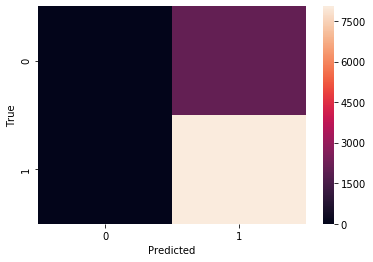

In [401]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_true=y_test, y_pred=clf.predict(X_test))
ax = sns.heatmap(conf_mat)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.show()

In [40]:
clf = DecisionTreeClassifier().fit(X_train, y_train)
print(clf.score(X_test, y_test))

for k,v in dict(zip(X.columns, clf.feature_importances_)).items():
    print("{}\t\t{}".format(k,v))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [36]:
tpot = TPOTClassifier(verbosity=2)
tpot.fit(X_train, y_train)

Imputing missing values in feature set


/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Generation 1 - Current best internal CV score: 0.8946990299892221
Generation 2 - Current best internal CV score: 0.8946990299892221
Generation 3 - Current best internal CV score: 0.8946990299892221
Generation 4 - Current best internal CV score: 0.8953701411497164
Generation 5 - Current best internal CV score: 0.8953701411497164
Generation 6 - Current best internal CV score: 0.8953701411497164


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesClassifier(GaussianNB(input_matrix), bootstrap=False, criterion=gini, max_features=0.8500000000000001, min_samples_leaf=5, min_samples_split=4, n_estimators=100)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=100,
               max_eval_time_mins=5, max_time_mins=None, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=100,
               random_state=None, scoring=None, subsample=1.0,
               template='RandomTree', use_dask=False, verbosity=2,
               warm_start=False)

In [39]:
tpot.score(X_test, y_test)

Imputing missing values in feature set


0.844

In [38]:
tpot.export('tpot_exported_pipeline.py')